In [31]:
import os
import cv2
import dlib
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

### Data Prep

In [29]:
# Initialize dlib's face detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('data_kaggle/shape_predictor_68_face_landmarks.dat')

def get_landmarks(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    if len(rects) > 0:
        shape = predictor(gray, rects[0])
        landmarks = np.array([[p.x, p.y] for p in shape.parts()])
        return landmarks
    return None

def pad_sequence(sequence, max_length):
    while len(sequence) < max_length:
        sequence.append(sequence[-1])
    return sequence

def load_and_preprocess_data(dataset_path):
    data = []
    labels = []
    max_length = 0
    i = 1
    # First pass to determine the maximum sequence length
    for person in tqdm(os.listdir(dataset_path)):
        person_path = os.path.join(dataset_path, person)
        words_path = os.path.join(person_path, 'words')
        if not os.path.isdir(words_path):
            continue
        print(i)
        i += 1
        for word in os.listdir(words_path):
            word_path = os.path.join(words_path, word)
            for example in os.listdir(word_path):
                example_path = os.path.join(word_path, example)
                landmarks_sequence = []
                for frame_file in os.listdir(example_path):
                    if frame_file.startswith('color'):
                        frame_path = os.path.join(example_path, frame_file)
                        image = cv2.imread(frame_path)
                        landmarks = get_landmarks(image)
                        if landmarks is not None:
                            landmarks_sequence.append(landmarks)
                if landmarks_sequence:
                    max_length = max(max_length, len(landmarks_sequence))

    i = 1
    # Second pass to load and pad the data
    for person in tqdm(os.listdir(dataset_path)):
        print(i)
        i += 1
        person_path = os.path.join(dataset_path, person)
        words_path = os.path.join(person_path, 'words')
        if not os.path.isdir(words_path):
            continue
        for word in os.listdir(words_path):
            word_path = os.path.join(words_path, word)
            for example in os.listdir(word_path):
                example_path = os.path.join(word_path, example)
                landmarks_sequence = []
                for frame_file in os.listdir(example_path):
                    if frame_file.startswith('color'):
                        frame_path = os.path.join(example_path, frame_file)
                        image = cv2.imread(frame_path)
                        landmarks = get_landmarks(image)
                        if landmarks is not None:
                            landmarks_sequence.append(landmarks)
                if landmarks_sequence:
                    padded_sequence = pad_sequence(landmarks_sequence, max_length)
                    data.append(padded_sequence)
                    labels.append(word)
        
    return np.array(data), np.array(labels)

dataset_path = 'data_kaggle/dataset/dataset/'
data, labels = load_and_preprocess_data(dataset_path)


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


100%|██████████| 1/1 [01:23<00:00, 83.20s/it]


In [60]:
def extract_lip_landmarks(data):
    lip_data = data[:, :, 48:68, :]
    return lip_data

lip_data = extract_lip_landmarks(data)


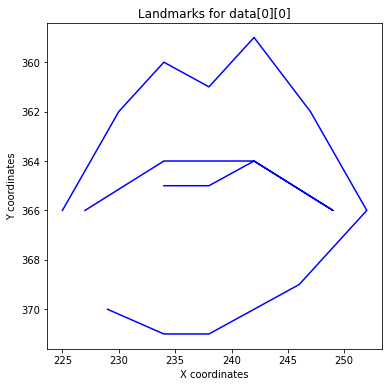

In [ ]:
import matplotlib.pyplot as plt

def plot_landmarks(landmarks):
    plt.figure(figsize=(6, 6))

    outer_lip = landmarks[48:60]
    inner_lip = landmarks[60:68]
    
    # Plot each region

    plt.plot(outer_lip[:, 0], outer_lip[:, 1], c='blue')
    plt.plot(inner_lip[:, 0], inner_lip[:, 1], c='blue')
    
    plt.gca().invert_yaxis()
    plt.title('Landmarks for data[0][0]')
    plt.xlabel('X coordinates')
    plt.ylabel('Y coordinates')
    plt.show()

example_landmarks = data[0][0]
plot_landmarks(example_landmarks)


### Training

In [46]:
# np.save('data.npy', data)
# np.save('labels.npy', labels)

In [32]:
data = np.load('data.npy')
labels = np.load('labels.npy')

In [34]:
int_to_word = {
    1: "begin",
    2: "choose",
    3: "connection",
    4: "navigation",
    5: "next",
    6: "previous",
    7: "start",
    8: "stop",
    9: "hello",
    10: "web"
}

vocab = set()
for word in int_to_word.values():
    for char in word:
        vocab.add(char)

vocab = sorted(list(vocab))

print(vocab)


['a', 'b', 'c', 'e', 'g', 'h', 'i', 'l', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x']


In [35]:
int2char = {i: char for i, char in enumerate(vocab)}
char2int = {char: i for i, char in enumerate(vocab)}

In [36]:
labels_int = np.array(labels).astype(int)
labels_ = np.array([int_to_word[label] for label in labels_int])

In [37]:
labels_tensor = []
for label in labels_:
    label_indices = [char2int[char] for char in label]
    labels_tensor.append(torch.tensor(label_indices, dtype=torch.int))

In [39]:
blank_label = len(char2int)
char2int['blank'] = blank_label
int2char = {i: char for char, i in char2int.items()}

In [40]:
labels_tensor = torch.nn.utils.rnn.pad_sequence(labels_tensor, batch_first=True, padding_value=blank_label)
target_lengths = torch.tensor([len(label) for label in labels], dtype=torch.int)
data_tensor = torch.tensor(data, dtype=torch.float)

In [46]:
dataset = TensorDataset(data_tensor, labels_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

class LipReadingRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LipReadingRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.input_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.LayerNorm(hidden_size)
        )
        
        self.bilstm = nn.LSTM(hidden_size, hidden_size, num_layers=3, batch_first=True, bidirectional=True, dropout=0.3)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for layer in self.input_layer:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)
        
        for name, param in self.bilstm.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
                
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x):
        x = self.input_layer(x)  
        h0 = torch.zeros(6, x.size(0), self.hidden_size).to(x.device)  
        c0 = torch.zeros(6, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.bilstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out)  
        
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = data_tensor.shape[2] * data_tensor.shape[3]
hidden_size = 512
num_classes = len(char2int) 
model = LipReadingRNN(input_size, hidden_size, num_classes).to(device)
criterion = nn.CTCLoss(blank=blank_label, reduction='mean', zero_infinity=True)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=200, gamma=0.1)


print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))


num_epochs = 200
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    model.train()
    for sequences, labels in train_loader:
        sequences = sequences.to(device)
        labels = labels.to(device)
        sequences = sequences.view(sequences.size(0), sequences.size(1), -1).to(device) # (batch_size, seq_len, input_size)
        
        outputs = model(sequences)
        
        outputs = outputs.permute(1, 0, 2)
        input_lengths = torch.full((sequences.size(0),), sequences.size(1), dtype=torch.long).to(device)
        target_lengths = torch.tensor([label[label != blank_label].size(0) for label in labels], dtype=torch.long).to(device)
        loss = criterion(outputs.log_softmax(2), labels, input_lengths, target_lengths).to(device)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    scheduler.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)
            sequences = sequences.view(sequences.size(0), sequences.size(1), -1).to(device) # (batch_size, seq_len, input_size)

            outputs = model(sequences)

            outputs = outputs.permute(1, 0, 2)
            input_lengths = torch.full((sequences.size(0),), sequences.size(1), dtype=torch.long).to(device)
            target_lengths = torch.tensor([label[label != blank_label].size(0) for label in labels], dtype=torch.long).to(device)
            loss = criterion(outputs.log_softmax(2), labels, input_lengths, target_lengths).to(device)

            val_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {total_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(test_loader):.4f}')


True
0
NVIDIA GeForce RTX 3060
Epoch [1/200], Training Loss: 3.7088, Validation Loss: 3.0234
Epoch [2/200], Training Loss: 2.9954, Validation Loss: 2.9023
Epoch [3/200], Training Loss: 2.8394, Validation Loss: 2.7155
Epoch [4/200], Training Loss: 2.6872, Validation Loss: 2.6043
Epoch [5/200], Training Loss: 2.5798, Validation Loss: 2.5297
Epoch [6/200], Training Loss: 2.5299, Validation Loss: 2.4880
Epoch [7/200], Training Loss: 2.4677, Validation Loss: 2.4359
Epoch [8/200], Training Loss: 2.4387, Validation Loss: 2.3726
Epoch [9/200], Training Loss: 2.4157, Validation Loss: 2.3970
Epoch [10/200], Training Loss: 2.4110, Validation Loss: 2.3791
Epoch [11/200], Training Loss: 2.3747, Validation Loss: 2.3294
Epoch [12/200], Training Loss: 2.3631, Validation Loss: 2.3044
Epoch [13/200], Training Loss: 2.3506, Validation Loss: 2.3214
Epoch [14/200], Training Loss: 2.3419, Validation Loss: 2.3039
Epoch [15/200], Training Loss: 2.3348, Validation Loss: 2.3290
Epoch [16/200], Training Loss: 2.

KeyboardInterrupt: 

In [53]:
import jiwer

def calculate_wer(reference, hypothesis):
    """
    Calculate the Word Error Rate (WER).
    - reference: The ground truth string.
    - hypothesis: The predicted string.
    Returns the WER as a float.
    """
    return jiwer.wer(reference, hypothesis)

def calculate_cer(reference, hypothesis):
    """
    Calculate the Character Error Rate (CER).
    - reference: The ground truth string.
    - hypothesis: The predicted string.
    Returns the CER as a float.
    """
    return jiwer.cer(reference, hypothesis)

def ctc_greedy_decoder(output, int2char, blank_label):
    """
    Decodes the output of the network using a greedy approach.
    - output: The raw output from the network.
    - int2char: A dictionary mapping indices to characters.
    - blank_label: The index of the blank label.
    Returns a list of decoded words.
    """
    decoded_words = []
    for batch in output:
        word = []
        prev_char = None
        for i in batch:
            char_idx = i.item()
            if char_idx != blank_label and (prev_char is None or char_idx != prev_char):
                word.append(int2char[char_idx])
            prev_char = char_idx
        decoded_words.append(''.join(word))
    return decoded_words

# Ensure the blank label is mapped to a space character if needed
# int2char[blank_label] = ' '

model.eval()
with torch.no_grad():
    total_val_loss = 0
    all_golden_words = []
    all_predicted_words = []
    for sequences, labels in test_loader:
        sequences = sequences.view(sequences.size(0), sequences.size(1), -1)  # Flatten the input dimensions
        
        sequences = sequences.to(device)
        labels = labels.to(device)
        
        outputs = model(sequences)
        
        max_indices = torch.argmax(outputs, dim=2)
        
        predicted_words = ctc_greedy_decoder(max_indices, int2char, blank_label)
        
        golden_words = []
        for label in labels:
            word = []
            for i in label:
                if i.item() != blank_label:  # Ignore the padding (blank) label
                    word.append(int2char[i.item()])
            golden_words.append(''.join(word))
        
        all_golden_words.extend(golden_words)
        all_predicted_words.extend(predicted_words)

total_cer = sum(calculate_cer(g, p) for g, p in zip(all_golden_words, all_predicted_words)) / len(all_golden_words)
total_wer = sum(calculate_wer(g, p) for g, p in zip(all_golden_words, all_predicted_words)) / len(all_golden_words)

character_accuracy = 1 - total_cer
word_accuracy = sum(1 for g, p in zip(all_golden_words, all_predicted_words) if g == p) / len(all_golden_words)

print(f'Final CER: {total_cer:.4f}')
print(f'Final WER: {total_wer:.4f}')
print(f'Character Accuracy: {character_accuracy:.4f}')
print(f'Word Accuracy: {word_accuracy:.4f}')


Final CER: 0.1054
Final WER: 0.1067
Character Accuracy: 0.8946
Word Accuracy: 0.8933
